# Project 3: Second-Order Systems

Sophie Wu and Becca Suchower

# Question: When a frog jumps off of a lilypad at a certain height, what is the minimum surface area of the lilypad so it does not submerge?

<img src="diagrams/force_graph.png" width=300 height=300> 
      
<img src="diagrams/force_graph_spline.png" width=300 height=300>

Source: https://pdfs.semanticscholar.org/3c26/3adf9dec3a122deb6d43492ba7b09cc5ac7e.pdf 

When researching frog jump studies, we found the above graph that shows force vs time for three different massed frogs.  In our model, we assumed the frog was point mass of 12.8 grams, as shown in the middle line of the above graph.  We also used the value of time associated with that frog, 80 ms, for the time that the frog is in contact with the lilypad.  The frog in the study was a striped marsh frog, which usually reaches about 70 mm in body length, meaning that the leg length would be about the same.  Finally, we assumed the lilypad was 1 cm tall above surface of water, and force was applied constantly to the lilypad.

# Model

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import scipy 
from numpy import sqrt, sin, cos, pi
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# import units needed in the model
s = UNITS.second
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter
degree = UNITS.degree

<Unit('degree')>

In [3]:
params = Params( 
                g_a = - 9.8 * m / s **2,   # gravitational acceleration
                height = 1 * m,            # height of the frog jump
                y_init = 0.01 * m,         # initial position, the height of the lilypad
                m_frog = 0.0128 * kg,      # mass of the frog, from the paper
                r_lilypad = 0.1 * m,       # radius of lilypad
                ρ = 997 * kg / m**3,       # density of water 
                #t_mid = 0.08 * s,          # the short time the frog applies force to the lilypad
                t_end = 300 * s,           # initializing t_end for ode solver
                force = 5 * N,             # initializing force
                leg_length = 0.07 * m       # length of frog legs
                )

,values
g_a,-9.8 meter / second ** 2
height,1 meter
y_init,0.01 meter
m_frog,0.0128 kilogram
r_lilypad,0.1 meter
ρ,997.0 kilogram / meter ** 3
t_end,300 second
force,5 newton
leg_length,0.07 meter


Calculating the volume of the lilypad/displaced water below and returning it to the system, calculating height and velocity at t_mid

In [4]:
def make_system(params):
    
    unpack(params)
    
    #setting value of t_mid to be based on force applied
    t_mid = ((2*leg_length)/(g_a + (force/m_frog)))**0.5
    
    # height and velocity at t_mid
    y_pos = y_init + (1/2)*(g_a + force/m_frog)*(t_mid**2)
    v_pos =(g_a + force/m_frog)*(t_mid)
    
    
    area = np.pi * (r_lilypad)**2
    volume = area * y_init             # volume of lilypad / displaced water
    
    init = State(y=y_pos, v=v_pos)
    
    #for debugging purposes
    #print(force)
    #print(y_pos)
    #print(v_pos)
    
    return System(params, volume = volume, init = init, y_pos = y_pos, v_pos = v_pos, t_mid = t_mid, area = area)

In [5]:
system = make_system(params)


,values
g_a,-9.8 meter / second ** 2
height,1 meter
y_init,0.01 meter
m_frog,0.0128 kilogram
r_lilypad,0.1 meter
ρ,997.0 kilogram / meter ** 3
t_end,300 second
force,5 newton
leg_length,0.07 meter
volume,0.00031415926535897936 meter ** 3


### Frog Jumping Vertically

In [6]:
def slope_func(state, t, system):

    y, v = state
    unpack(system)
    
    dydt = v                              #velocity at certain point
    dvdt = g_a                            #acceleration due to gravity 
    
    return dydt, dvdt

In [7]:
slope_func(system.init, 0, system)

(<Quantity(7.3017463664523445, 'meter / second')>,
 <Quantity(-9.8, 'meter / second ** 2')>)

In [8]:
def event_func(state, t, system):
    y, v = state
    return y

In [9]:
results, details = run_ode_solver(system, slope_func, events=event_func, max_step=0.1*s)
details.message
results

,y,v
0.000000,8.000000e-02,7.301746
0.015589,1.926351e-01,7.148976
0.115589,8.585327e-01,6.168976
0.215589,1.426430e+00,5.188976
0.315589,1.896328e+00,4.208976
0.415589,2.268225e+00,3.228976
0.515589,2.542123e+00,2.248976
0.615589,2.718020e+00,1.268976
0.715589,2.795918e+00,0.288976
0.815589,2.775816e+00,-0.691024


5 newton 2.7959180165640016


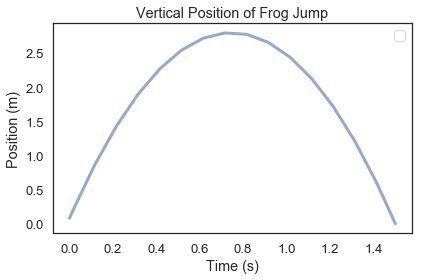

In [10]:
def plot_position(results):
    plot(results.y)
    decorate(title='Vertical Position of Frog Jump',
             xlabel='Time (s)',
             ylabel='Position (m)')
    
plot_position(results)

max_height = results.y.max()

print(force, max_height)

In [11]:
def sweep_force(force_array, params):
    sweep = SweepSeries()
    
    for force in force_array:
        
        system = make_system(Params(params, y_pos = y_pos, v_pos = v_pos, force = force))
        
        tpoints = linrange(0.1, 3, 0.1)
        
        results, details = run_ode_solver(system, slope_func, 
                                          events=event_func, 
                                          t_eval = tpoints, 
                                          max_step = 0.01 * s)
        max_height = results.y.max()
        sweep[force.magnitude] = max_height
        
    return sweep


In [12]:
force_array = linspace(1, 10, 10) * N 
sweep = sweep_force(force_array, params);

1     0.566844
2     1.119012
3     1.680310
4     2.235887
5     2.790222
6     3.356638
7     3.915121
8     4.463466
9     5.032182
10    5.582694
dtype: float64


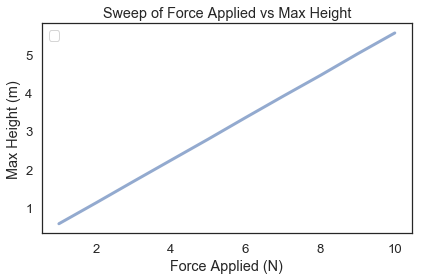

In [13]:
plot(sweep)
print(sweep)

decorate(title='Sweep of Force Applied vs Max Height',
         xlabel='Force Applied (N)', 
         ylabel='Max Height (m)')

When the force applied by the frog jumping is equal to the buoyant force due to the water, then we know the lilypad has been submerged in water.

In [14]:
# motion of lilypad

F_lily = - ρ * volume * g_a    # buoyant force
   
#print("Force of Frog (N)\tMax Height (m)\tBuoyant Force (N)\tResult \tOld Area (sq.m) \tNew Area (sq.m)")

print("Force of\tMax\t        Buoyant\t   Result\tOld Lilypad\tNew Lilypad")
print("Frog (N)\tHeight (m)\tForce (N)\t   \tArea (sq.m) \tArea (sq.m)")
    
for force in force_array:

    F_frog = force

    print("  %.0f\t        %.3f\t        %.3f"%(force.magnitude,sweep[force.magnitude],F_lily.magnitude),end=" ")
    
    #print('Max Height: ', sweep[force.magnitude])
    #print('Force of Frog: ', F_frog)
    #print('Buoyant Force: ', F_lily)

    if F_frog >= F_lily: 
        new_area = (F_frog/(- ρ * y_init  * g_a))
        
        print("\t   sink \t%.3f\t        %.3f"%(system.area.magnitude,new_area.magnitude))
        #print('Result: sink')
        #print('Old Lilypad Area: ', system.area)
        #print('New Lilypad Area: ', new_area)
    else: 
        print("\t   float\t%.3f\t        %.3f"%(system.area.magnitude,system.area.magnitude))
        #print("Result: float")
        #print('Old Lilypad Area: ', system.area)
        #print('New Lilypad Area: ', system.area)


Force of	Max	        Buoyant	   Result	Old Lilypad	New Lilypad
Frog (N)	Height (m)	Force (N)	   	Area (sq.m) 	Area (sq.m)
  1	        0.567	        3.070 	   float	0.031	        0.031
  2	        1.119	        3.070 	   float	0.031	        0.031
  3	        1.680	        3.070 	   float	0.031	        0.031
  4	        2.236	        3.070 	   sink 	0.031	        0.041
  5	        2.790	        3.070 	   sink 	0.031	        0.051
  6	        3.357	        3.070 	   sink 	0.031	        0.061
  7	        3.915	        3.070 	   sink 	0.031	        0.072
  8	        4.463	        3.070 	   sink 	0.031	        0.082
  9	        5.032	        3.070 	   sink 	0.031	        0.092
  10	        5.583	        3.070 	   sink 	0.031	        0.102


From the table above, we can see that when the force exerted by the frog exceeds the buoyant force (which is between 3 and 4 Newton), the lilypad is going to sink. Thus, we know that the maximum height reached by the frog is 1.680 m. 

### Extending to 2-D motion 

In [15]:
params1 = Params(params, velocity = system.v_pos, 
                 angle = 45 * degree, 
                 p_x = 0.01 * m,
                 p_y = 0.01 * m)

,values
g_a,-9.8 meter / second ** 2
height,1 meter
y_init,0.01 meter
m_frog,0.0128 kilogram
r_lilypad,0.1 meter
ρ,997.0 kilogram / meter ** 3
t_end,300 second
force,5 newton
leg_length,0.07 meter
velocity,7.3017463664523445 meter / second


In [16]:
# set up system values

# the frog is treated as point mass



def make_system1(params):

    unpack(params)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x_frog = p_x,
                 y_frog = p_y,
                 vx = vx,
                 vy = vy)
    
    # compute area from radius
    area = np.pi * r_lilypad **2
    
    return System(params, init=init, area=area)

In [17]:
system2 = make_system1(params1)


,values
g_a,-9.8 meter / second ** 2
height,1 meter
y_init,0.01 meter
m_frog,0.0128 kilogram
r_lilypad,0.1 meter
ρ,997.0 kilogram / meter ** 3
t_end,300 second
force,5 newton
leg_length,0.07 meter
velocity,7.3017463664523445 meter / second


In [18]:
def slope_func(state, t, system):

    p_x, p_y, vx, vy = state
    unpack(system)

    V = Vector(vx, vy)
    
    a_grav = Vector(0, g_a)

    return vx, vy, a_grav.x, a_grav.y

In [19]:
# we test it with the initial condition
slope_func(system2.init, 0, system2)

(<Quantity(5.1631143702226865, 'meter / second')>,
 <Quantity(5.1631143702226865, 'meter / second')>,
 <Quantity(0.0, 'meter / second ** 2')>,
 <Quantity(-9.8, 'meter / second ** 2')>)

In [20]:
def event_func(state, t, system):

    x_frog, y_frog, vx, vy = state
    return y_frog

In [21]:
results1, details = run_ode_solver(system2, slope_func, events=event_func, max_step=0.01*s)


In [22]:
details

,values
sol,None
t_events,[[1.055630078700011]]
nfev,644
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


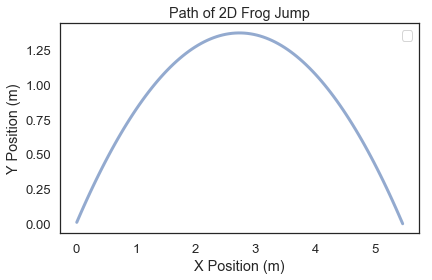

In [23]:
def plot_position(results):
    plot(results1.x_frog, results1.y_frog)
    decorate(title='Path of 2D Frog Jump',
             xlabel='X Position (m)',
             ylabel='Y Position (m)')
    
plot_position(results1)

In [24]:
def range_func(angle, params):  

    params1 = Params(params, angle=angle)
    system1 = make_system1(params1)
    results1, details = run_ode_solver(system1, slope_func, events=event_func, max_step=0.01*s)
    height = max(results1.y_frog) * m
    return height

In [25]:
angles = linspace(20, 80, 21)
sweep1 = SweepSeries()

for angle in angles:
    height = range_func(angle, params)
    print(angle, height)
    sweep1[angle] = height

20.0 0.32818177093077944 meter
23.0 0.4252767969718946 meter
26.0 0.5326661334451697 meter
29.0 0.649338288851766 meter
32.0 0.7738467291000444 meter
35.0 0.9048130441804686 meter
38.0 1.0409689360152363 meter
41.0 1.180720472734259 meter
44.0 1.3225148697864682 meter
47.0 1.4649440214529188 meter
50.0 1.6062443407328832 meter
53.0 1.7449577259245257 meter
56.0 1.8794739942120837 meter
59.0 2.008525100755537 meter
62.0 2.1305198315287686 meter
65.0 2.244309850840154 meter
68.0 2.3484349222104965 meter
71.0 2.4418416537764656 meter
74.0 2.5234559357794666 meter
77.0 2.592482312098582 meter
80.0 2.6481513717800533 meter


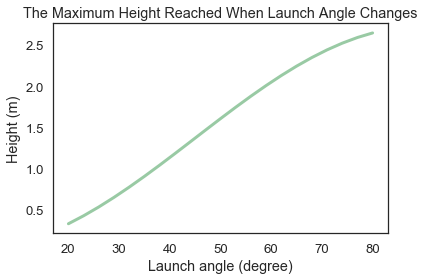

In [26]:
plot(sweep1, color='C2')
decorate(xlabel='Launch angle (degree)',
         ylabel='Height (m)',
         title='The Maximum Height Reached When Launch Angle Changes',
         legend=False)

# Interpretation

By comparing this graph to the one we generated in Force vs Max Height, we can find the relationship between the angle of frog jump and the force that is exerted on the lilypad, given a certian magnitude of velocity. 

It is determined in the first section that the maximum height reached by the frog without sinking the lilypad is 1.680 m. According to the graph above, the launch angle of this frog must be smaller than 55 degrees in order not to make the lilypad sink, given a fixed initial velocity. 

As the frog is jumping with an angle, the verticle part of the total force exerted on the lilpad causes a downward pressure. The height of a frog jump is also determined by the verticle force exerted on lilypad when jumping. Thus, there is a correlation between the angle of jumping and the maximum height reached by the frog without sinking the lilypad. 